In [ ]:
import requests
from dotenv import load_dotenv
from datetime import datetime

import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx

In [3]:
# API URLs
BASE_URL_STAC = "https://geoservice.dlr.de/eoc/ogc/stac/v1"
#BASE_URL_STAC = "https://planetarycomputer.microsoft.com/api/stac/v1"

In [ ]:
def datetime_to_numeric(datetime_str):
    try:
        dt = datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S.%fZ")
        return dt.timestamp()
    except (ValueError, TypeError):
        return None
    
def get_all_items(collection_id, max_pages=None):
    items = []
    next_link = f"{BASE_URL_STAC}/collections/{collection_id}/items"
    pages_checked = 0

    while next_link:
        response = requests.get(next_link)
        response.raise_for_status()
        data = response.json()
        items.extend(data.get("features", []))

        # Check if there is a "next" link for pagination
        next_link = None
        for link in data.get("links", []):
            if link.get("rel") == "next":
                next_link = link.get("href")
                break

        # Increment the page counter and stop if max_pages is reached
        pages_checked += 1
        if max_pages is not None and pages_checked >= max_pages:
            print(f"Stopped checking next pages at {max_pages}.")
            break

    return items

def get_stac_collections(max_pages=None):
    response_col = requests.get(f"{BASE_URL_STAC}/collections")
    response_col.raise_for_status()
    collections = response_col.json()["collections"][:2]

    collections_with_items = []
    for col in collections:
        col_id = col.get("id")
        items = get_all_items(col_id, max_pages=max_pages)
        items_filtered = []
        for itm in items:
            items_filtered.append({
                "id": itm.get("id"),
                "datetime": datetime_to_numeric(itm.get("properties", {}).get("datetime"))
            })
        # Sort items by datetime
        items_filtered.sort(key=lambda x: x["datetime"] if x["datetime"] is not None else 0)
        collections_with_items.append({
            "id": col_id,
            "items": items_filtered
        })
    return collections_with_items

In [40]:
collections_35 = get_stac_collections(max_pages=35)
collections_35

700
680


[{'id': 'SWIM_WE',
  'items': [{'id': 'SWIM_WE_S1C_IW_GRDH_1SDV_20250917T182655_20250917T182720_004168_00846C_9D0D',
    'datetime': 1758126415.855126},
   {'id': 'SWIM_WE_S1C_IW_GRDH_1SDV_20250917T182720_20250917T182745_004168_00846C_824E',
    'datetime': 1758126440.855796},
   {'id': 'SWIM_WE_S1C_IW_GRDH_1SDV_20250917T182950_20250917T183015_004168_00846C_B7A4',
    'datetime': 1758126590.855301},
   {'id': 'SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183015_20250917T183040_004168_00846C_FE9F',
    'datetime': 1758126615.855969},
   {'id': 'SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183040_20250917T183105_004168_00846C_A450',
    'datetime': 1758126640.855139},
   {'id': 'SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183308_20250917T183337_004168_00846D_A4F6',
    'datetime': 1758126788.563341},
   {'id': 'SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183337_20250917T183402_004168_00846D_6C1B',
    'datetime': 1758126817.8543},
   {'id': 'SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183402_20250917T183427_004168_00846D_5111',
    'datet

In [70]:
def generate_one_graph(item_list):
    item_ids = [item.get("id") for item in item_list]
    item_dts = [item.get("datetime") for item in item_list]
    G = nx.path_graph(item_ids)

    # add datetime to each node
    for i, node in enumerate(G.nodes()):
        G.nodes[node]["datetime"] = item_dts[i]

    ## convert the graph information to data ready to use by Pytorch Geometric
    data = from_networkx(G)

    # convert price attribute to node feature tensor [num_nodes, 1]
    data.x = torch.tensor([[G.nodes[i]["datetime"]] for i in G.nodes()],
        dtype=torch.float)
    
    label = 1 if G.number_of_nodes() > 680  else 0

    y = torch.tensor([[label]], dtype=torch.float)

    data.y = y

    return G, data

def visualize_graph( G, item_list, graph_label=None):
    pos = nx.spring_layout(G, seed=42)

    item_ids = [item.get("id") for item in item_list]
    item_dts = [item.get("datetime") for item in item_list]
    labels = {i: f"{item_dts[c]:.1f}" for c,i in enumerate(item_ids)}
    print(labels)

    node_colors = [G.nodes[n]['datetime'] for n in G.nodes()]
    fig, ax = plt.subplots(figsize=(20, 15))

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        cmap=plt.cm.coolwarm,
        node_size=500,
        edge_color="gray",
        with_labels=False
    )
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=5)

    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap=plt.cm.coolwarm),
        ax=ax,
        label="Datetime (seconds since epoch)"
    )

    if graph_label is not None:
        plt.title(f"Collection: {graph_label}")
    else:
        plt.title("Fully Connected Graph\n(Node label = Datetime)")
    plt.axis("off")
    plt.show()

[('SWIM_WE_S1C_IW_GRDH_1SDV_20250917T182655_20250917T182720_004168_00846C_9D0D', {'datetime': 1758126415.855126}), ('SWIM_WE_S1C_IW_GRDH_1SDV_20250917T182720_20250917T182745_004168_00846C_824E', {'datetime': 1758126440.855796}), ('SWIM_WE_S1C_IW_GRDH_1SDV_20250917T182950_20250917T183015_004168_00846C_B7A4', {'datetime': 1758126590.855301}), ('SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183015_20250917T183040_004168_00846C_FE9F', {'datetime': 1758126615.855969}), ('SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183040_20250917T183105_004168_00846C_A450', {'datetime': 1758126640.855139}), ('SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183308_20250917T183337_004168_00846D_A4F6', {'datetime': 1758126788.563341}), ('SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183337_20250917T183402_004168_00846D_6C1B', {'datetime': 1758126817.8543}), ('SWIM_WE_S1C_IW_GRDH_1SDV_20250917T183402_20250917T183427_004168_00846D_5111', {'datetime': 1758126842.854198}), ('SWIM_WE_S1A_IW_GRDH_1SDV_20250918T035507_20250918T035536_061037_079B25_A76C', {'datetim

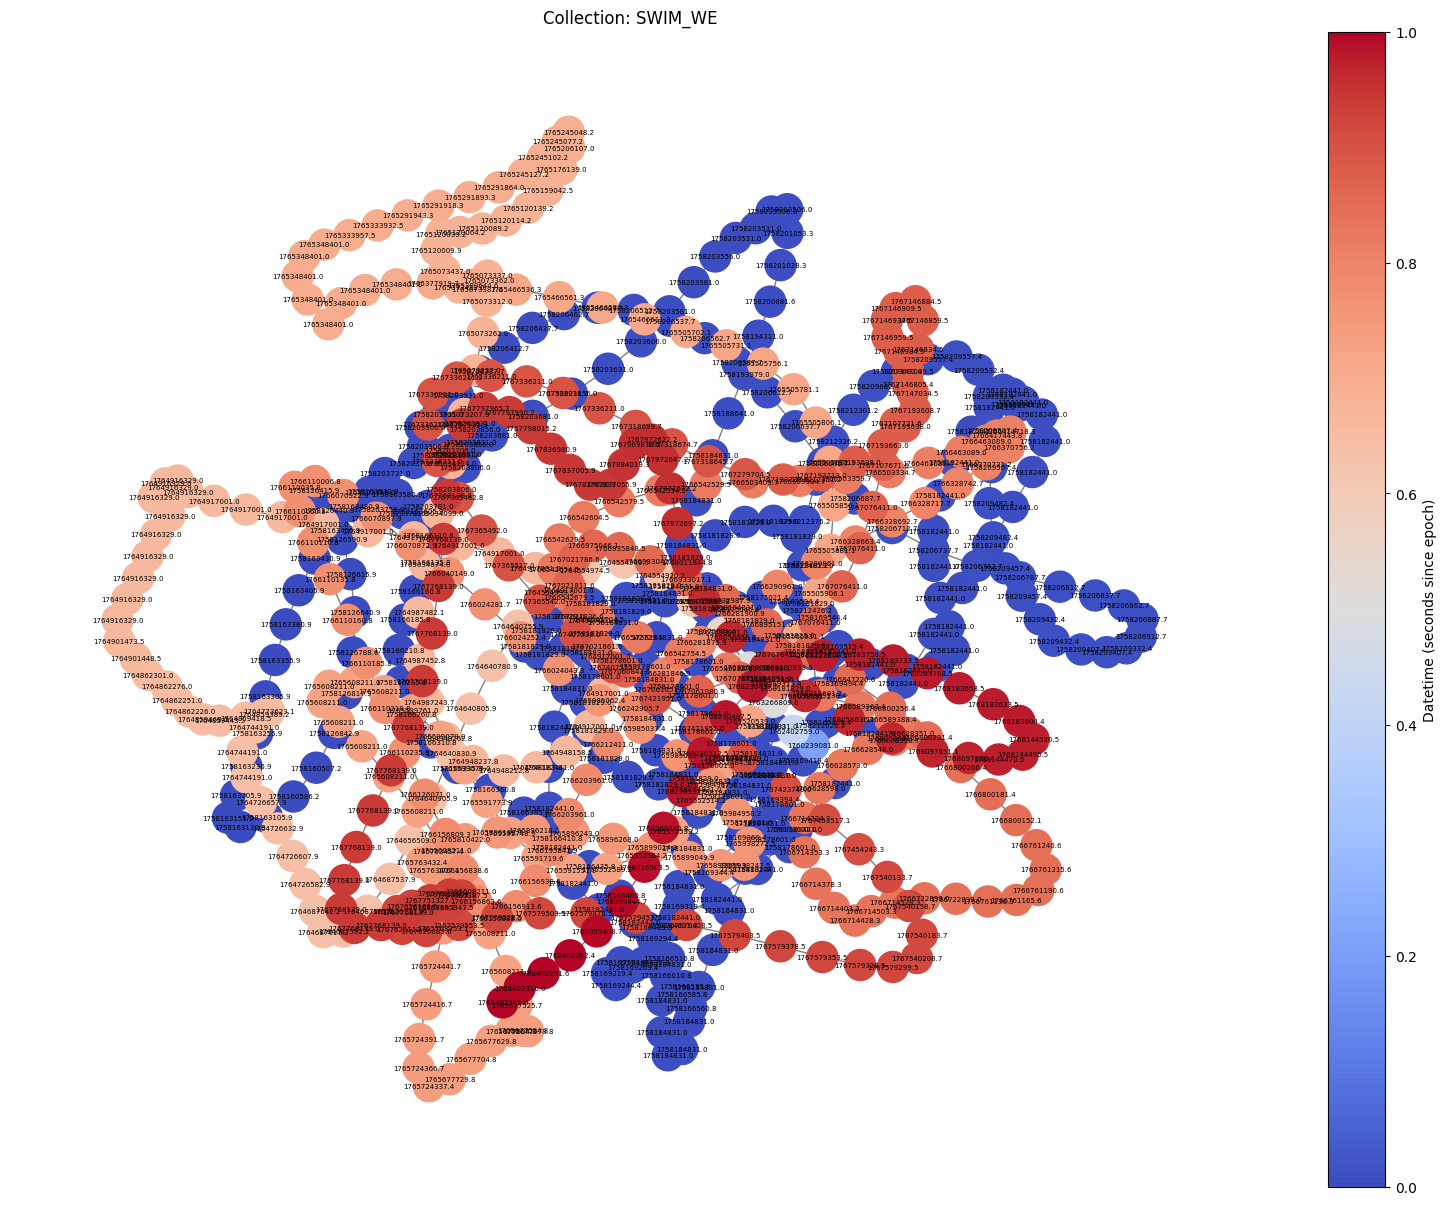

[('S5P_DLR_NRTI_01_040100_L3_CF_20230801', {'datetime': 1690884752.2915}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230802', {'datetime': 1690970578.3915}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230803', {'datetime': 1691056592.469}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230804', {'datetime': 1691142853.6825}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230805', {'datetime': 1691229938.999}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230806', {'datetime': 1691316927.54}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230807', {'datetime': 1691402781.547}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230808', {'datetime': 1691488696.0125}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230809', {'datetime': 1691574953.071}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230810', {'datetime': 1691660800.0285}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230811', {'datetime': 1691750481.9585}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230812', {'datetime': 1691834721.3455}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230813', {'datetime': 1691921971.2225}), ('S5P_DLR_NRTI_01_040100_L3_CF_20230814', {

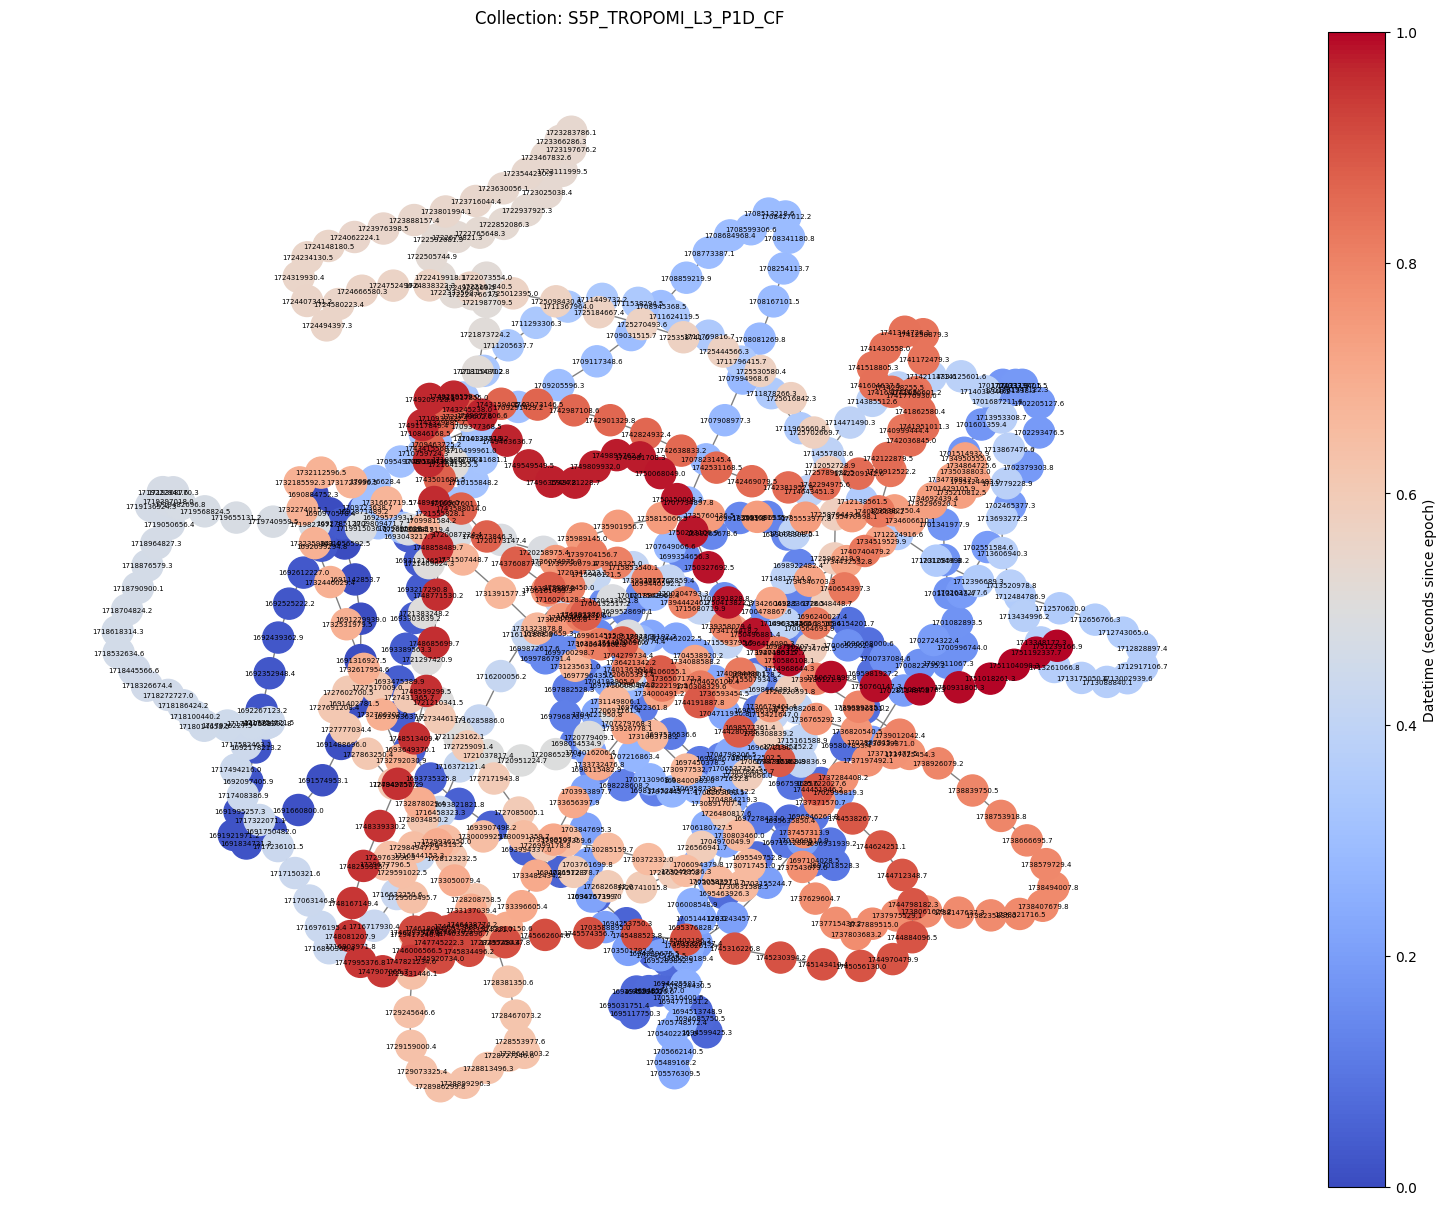

In [69]:
for col in collections_35:
    col_items = col.get("items")
    col_id = col.get("id")
    G, data = generate_one_graph(col_items)
    print(G.nodes(data=True))
    print(data)
    visualize_graph(G, col_items,  graph_label=col_id)